# Runing the adaptive speciation model with fastscape

In [1]:
import numpy as np
import pandas as pd
import xsimlab as xs
import matplotlib.pyplot as plt

from fastscape.models import basic_model

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from adascape.fastscape_ext import IR12Speciation, DD03Speciation
from adascape.fastscape_ext import FastscapeElevationTrait, FastscapePrecipitationTrait
from adascape.fastscape_ext import CompoundEnvironment, ElevationEnvField, PrecipitationField
from adascape.fastscape_ext import RandomSeedFederation
from orographic_precipitation.fastscape_ext import OrographicPrecipitation, OrographicDrainageDischarge

## Speciation without competition in an evolving landscape

In [2]:
model = basic_model.update_processes({
    'life': IR12Speciation,
    'trait_elev':FastscapeElevationTrait,
    'trait_prep':FastscapePrecipitationTrait,
    'life_env': CompoundEnvironment,
    'elev_field':ElevationEnvField,
    'prec_field': PrecipitationField,
    'random': RandomSeedFederation,
    'orographic': OrographicPrecipitation,
    'drainage': OrographicDrainageDischarge
})

model

<xsimlab.Model (24 processes, 45 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                   [in] random seed
surf2erode
flow
orographic
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] background, non-orographic precipit...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
    conv_time              [in] conversion time
    fall_time              [in] fallout time
    nm

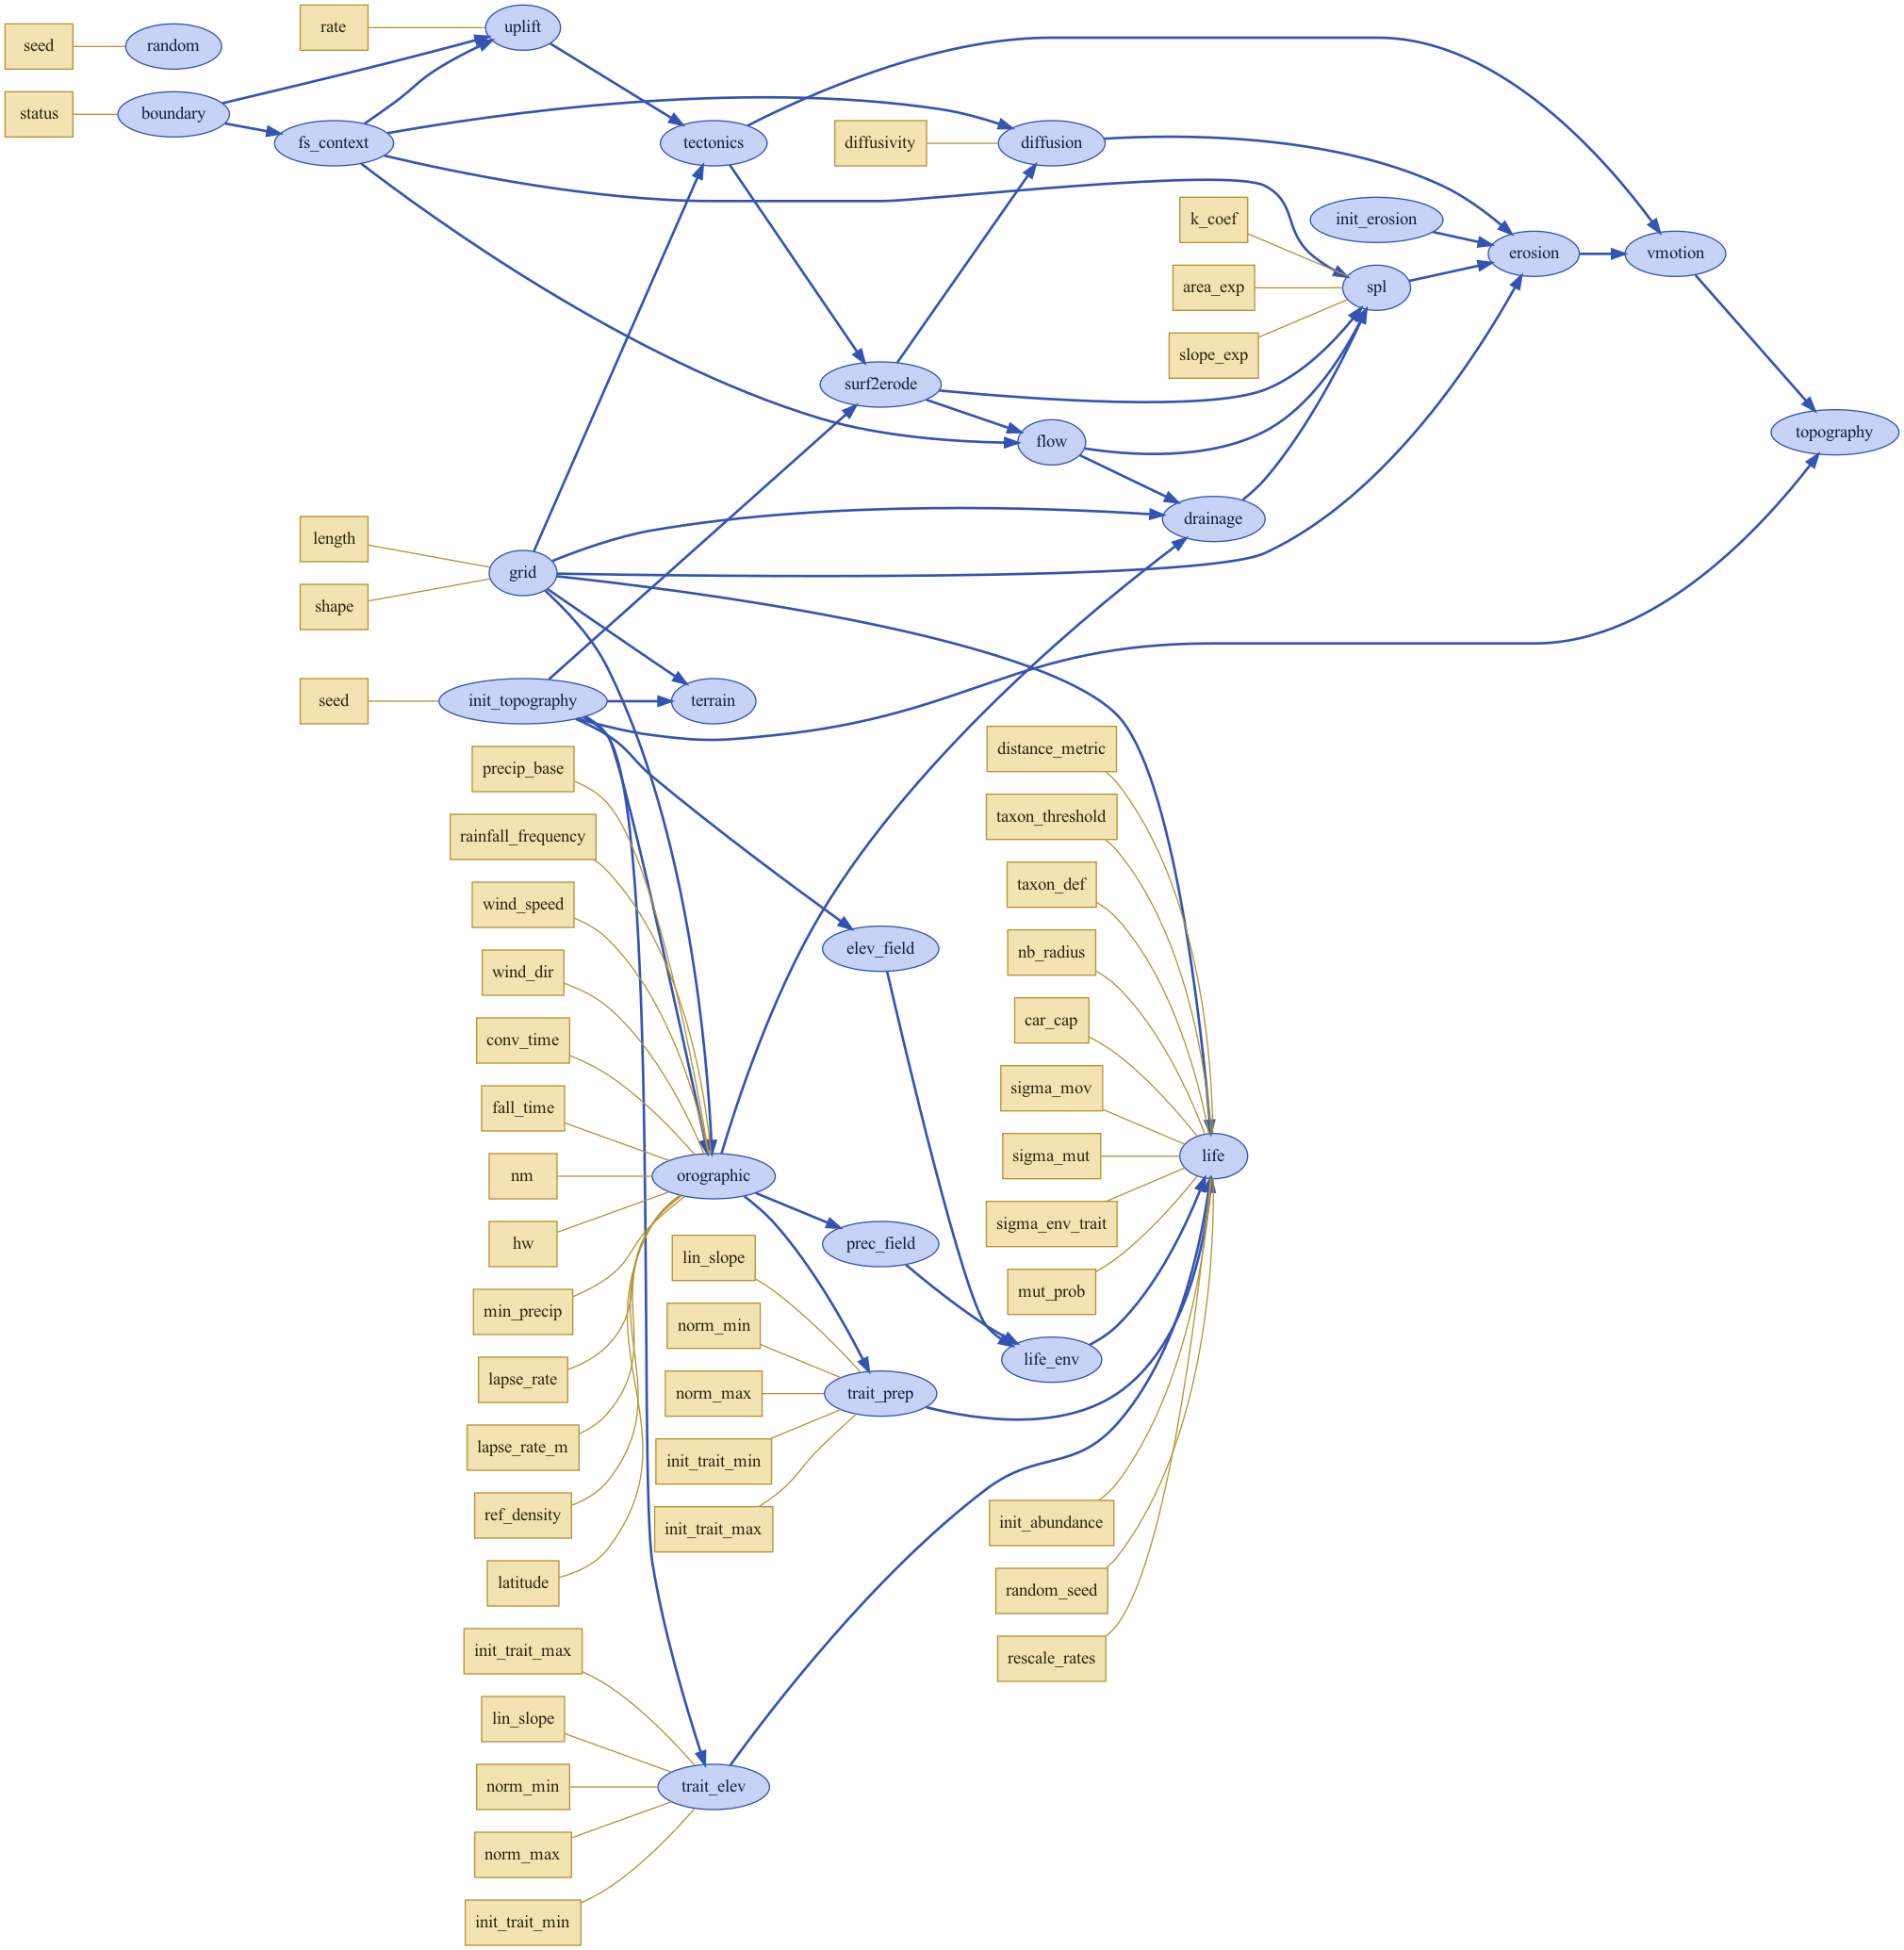

In [3]:
model.visualize(show_inputs=True)

In [4]:
random_seed = 1234
uplift_rate = 5e-3
hmax = 3500
time = np.linspace(0., 1e6, 1001)
in_ds = xs.create_setup(
    model=model,
    clocks={
        'time': time,
        'out': time[::10]
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 201], 
        'grid__length': [1e5, 2e5], 
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': uplift_rate,
        'spl__k_coef': (uplift_rate/hmax)*50,
        'spl__area_exp': 0.4,
        'spl__slope_exp': 1,
        'diffusion__diffusivity': 3e-2,
        'init_topography__seed': random_seed,
        'random':{'seed': random_seed},
        'orographic':{
            'rainfall_frequency':0.1,
            'latitude': 10, 
            'precip_base': 5,         
            'wind_speed': 10,          
            'wind_dir': 360,            
        },
        'trait_elev': {
            'init_trait_min':0.5,
            'init_trait_max':0.5,
            'lin_slope':0.95,
            'norm_min':0,
            'norm_max':hmax,
        },
        'trait_prep': {
            'init_trait_min':0.5,
            'init_trait_max':0.5,
            'lin_slope':0.95,
            'norm_min':0,
            'norm_max':7,
        },
        'life': {
            'init_abundance': 100,
            'nb_radius': 2e4,
            'car_cap': 25,
            'sigma_mov': 1000.,
            'mut_prob': 0.5,
            'sigma_mut': 0.05, 
            'sigma_env_trait': 0.5,
            'random_seed':random_seed,
            'taxon_threshold':0.05
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'orographic__precip_rate':'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__traits': 'out',
        'life__taxon_id': 'out',
        'life__ancestor_id': 'out'
    }
)

In [5]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model)

             0% | initialize 

/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


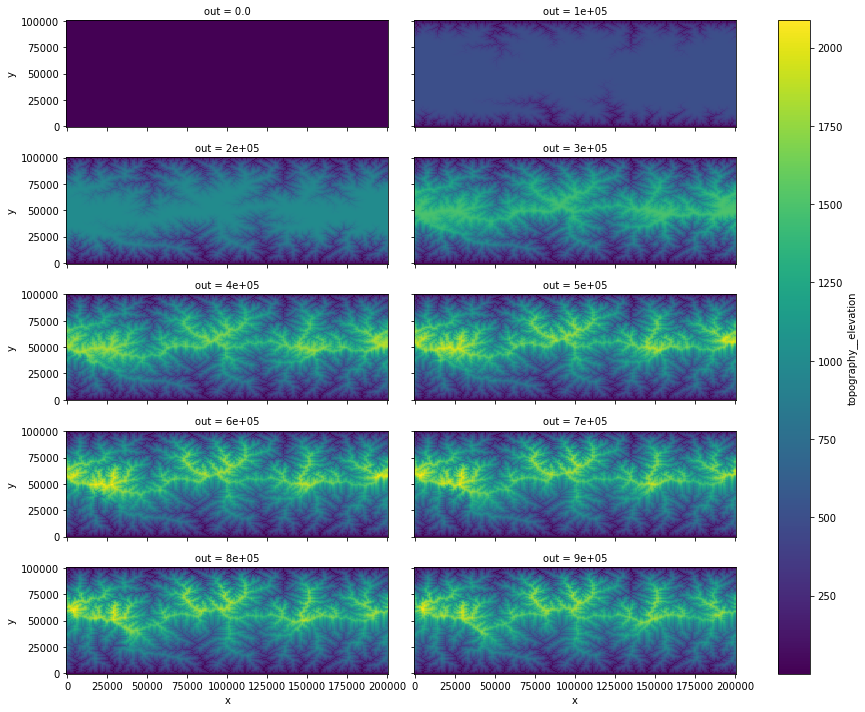

In [6]:
time_sel = np.arange(0, 1e6, 1e5)
elev_max = out_ds.topography__elevation.max()
out_ds.sel(out=time_sel).topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10))

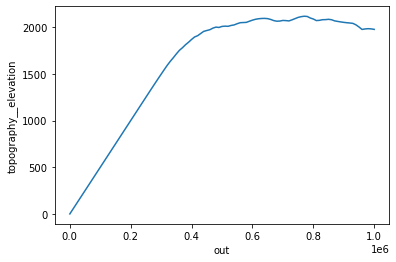

In [7]:
out_ds.topography__elevation.max(('x', 'y')).plot()

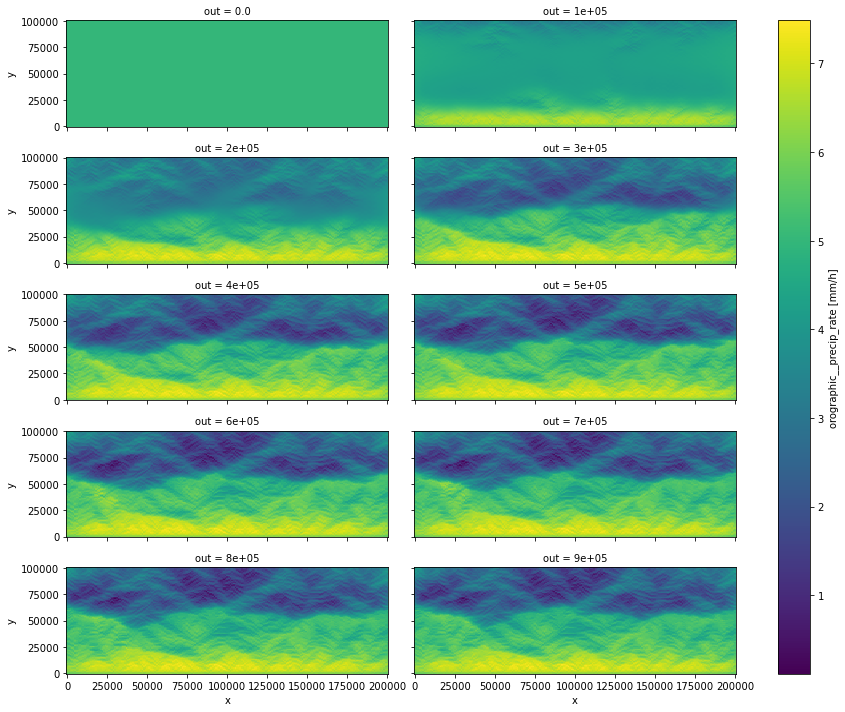

In [8]:
out_ds.sel(out=time_sel).orographic__precip_rate.plot(col='out', col_wrap=2, figsize=(13, 10))

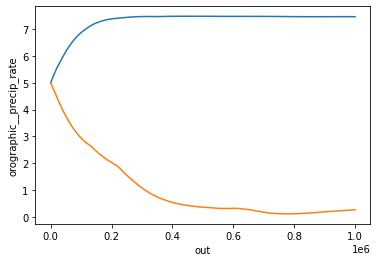

In [9]:
out_ds.orographic__precip_rate.max(('x', 'y')).plot()
out_ds.orographic__precip_rate.min(('x', 'y')).plot()

In [10]:
def get_dataframe(ds):
    individuals_data = {}
    for i in range(ds.life__traits.shape[2]):
        individuals_data['life__' + str(ds.trait[i].values.astype(str))] = ds.life__traits[:, :, i]
    ds = ds.assign(individuals_data)
    out_vars = ['life__taxon_id', 'life__ancestor_id', 'life__trait_elev', 'life__trait_prep', 'life__y', 'life__x']
    out_ds = ds[out_vars]

    dtf = (
        out_ds
            .to_dataframe()
            .rename(columns=lambda name: name.replace('life__', ''))
            .reset_index()
            .dropna()
    )
    return dtf

In [11]:
df1 = get_dataframe(out_ds)
df1

,out,ind,taxon_id,ancestor_id,trait_elev,trait_prep,y,x
0,0.0,0,1.0,0.0,0.500000,0.500000,29784.009062,195339.953340
1,0.0,1,1.0,0.0,0.500000,0.500000,61916.101637,76039.147004
2,0.0,2,1.0,0.0,0.500000,0.500000,30175.742962,184649.246753
3,0.0,3,1.0,0.0,0.500000,0.500000,17484.645113,52338.484773
4,0.0,4,1.0,0.0,0.500000,0.500000,49550.519522,63819.411683
...,...,...,...,...,...,...,...,...
52508,1000000.0,508,44530.0,43598.0,0.438095,0.944931,17644.171260,5872.541700
52509,1000000.0,509,44530.0,43598.0,0.195428,0.843527,11442.907941,2397.559692
52510,1000000.0,510,44555.0,43623.0,0.678211,0.503368,52008.724683,25695.078426
52511,1000000.0,511,44485.0,43553.0,0.372475,0.584842,62276.027223,59028.506641


## Plot population

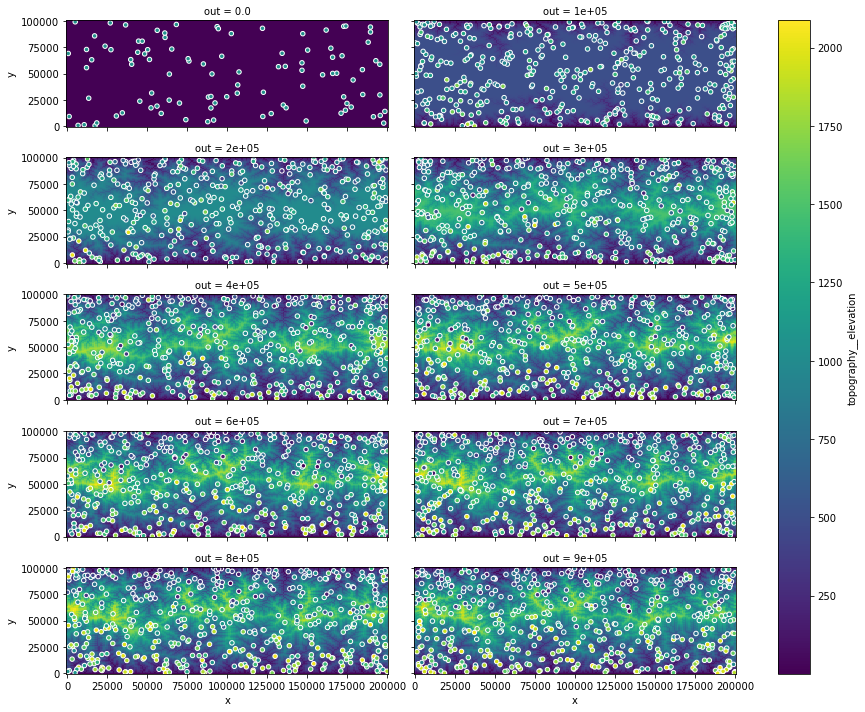

In [12]:
fg = (out_ds
      .sel(out=time_sel)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), time_sel):
    pop = df1[df1.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait_prep, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time [years]')

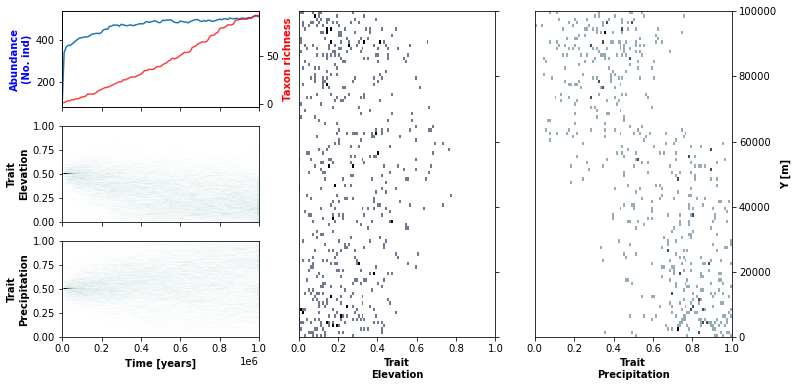

In [13]:
fig2, axs2 = plt.subplots(3, 3, sharex="col", figsize=(12, 6))
gs2 = axs2[1, 1].get_gridspec()
for ax in axs2[0:, 1:].flatten():
    ax.remove()
axbig0 = fig2.add_subplot(gs2[0:, -2])
axbig1 = fig2.add_subplot(gs2[0:, -1])
axs2[0,0].plot(df1.groupby('out').size())
axs2_2 = axs2[0,0].twinx()
axs2_2.plot(df1.groupby(['out']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)
h,xedge,yedge,_=axs2[1,0].hist2d(x=df1['out'], y=df1['trait_elev'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs2[2,0].hist2d(x=df1['out'], y=df1['trait_prep'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig0.hist2d(x=df1['trait_elev'].loc[df1['out']==max(df1['out'])], 
                             y=df1['y'].loc[df1['out']==max(df1['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig1.hist2d(x=df1['trait_prep'].loc[df1['out']==max(df1['out'])], 
                             y=df1['y'].loc[df1['out']==max(df1['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
axbig0.yaxis.set_tick_params(labelleft=False)
axbig1.yaxis.set_label_position("right")
axbig0.yaxis.tick_right()
axbig1.yaxis.tick_right()
axbig0.set_xlabel('Trait\nElevation', weight='bold')
axbig1.set_xlabel('Trait\nPrecipitation', weight='bold')
axbig1.set_ylabel('Y [m]', weight='bold')
axs2[0,0].set_ylabel('Abundance\n(No. ind)', weight='bold', color='blue')
axs2_2.set_ylabel('Taxon richness', weight='bold', color='red')
axs2[1,0].set_ylabel('Trait\nElevation', weight='bold')
axs2[2,0].set_ylabel('Trait\nPrecipitation', weight='bold')
axs2[2,0].set_xlabel('Time [years]', weight='bold')

## Speciation with competition in an evolving landscape

In [14]:
with model.update_processes({'life': DD03Speciation}), xs.monitoring.ProgressBar():
    out_ds2 = in_ds.xsimlab.update_vars(input_vars={'life': {
            'init_abundance': 100,
            'birth_rate': 1.0,
            'movement_rate': 5.,
            'car_cap_max': 500.,
            'mut_prob': 0.5,
            'sigma_mut': 0.05,
            'sigma_mov': 1000.,
            'sigma_env_trait': 0.5,
            'sigma_comp_trait': 0.5,
            'sigma_comp_dist': 0.5,
            'random_seed': random_seed,
            'taxon_threshold':0.05
        }
    }   
    ).xsimlab.run(check_dims='transpose')

             0% | initialize 

/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [15]:
df2 = get_dataframe(out_ds2)

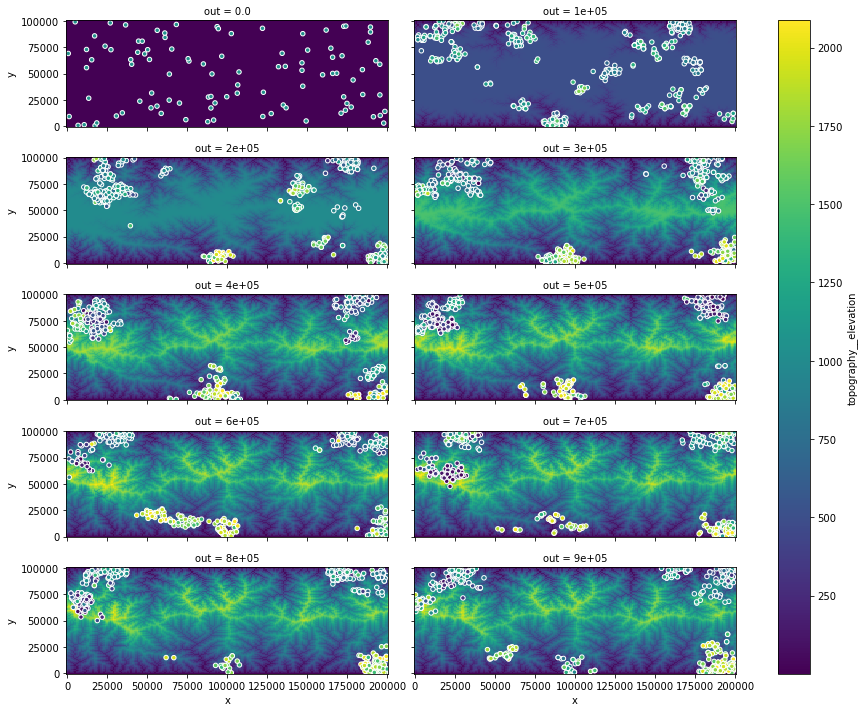

In [16]:
fg = (out_ds2
      .sel(out=time_sel)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), time_sel):
    pop = df2[df2.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait_prep, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time [years]')

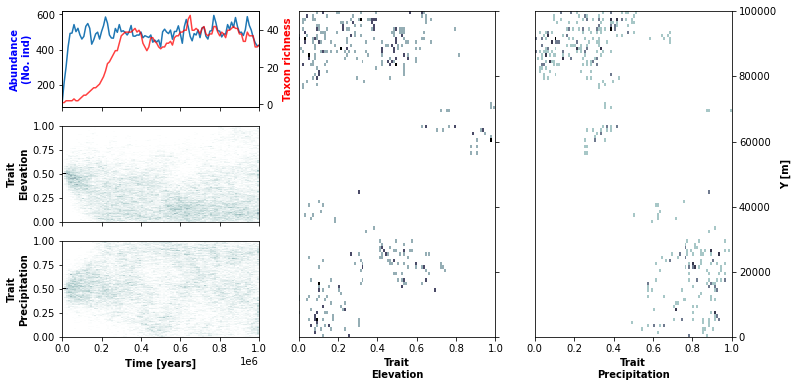

In [17]:
fig5, axs5 = plt.subplots(3, 3, sharex="col", figsize=(12, 6))
gs5 = axs5[1, 1].get_gridspec()
for ax in axs5[0:, 1:].flatten():
    ax.remove()
ax5big0 = fig5.add_subplot(gs5[0:, -2])
ax5big1 = fig5.add_subplot(gs5[0:, -1])
axs5[0,0].plot(df2.groupby('out').size())
axs5_2 = axs5[0,0].twinx()
axs5_2.plot(df2.groupby(['out']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)
h,xedge,yedge,_=axs5[1,0].hist2d(x=df2['out'], y=df2['trait_elev'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs5[2,0].hist2d(x=df2['out'], y=df2['trait_prep'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=ax5big0.hist2d(x=df2['trait_elev'].loc[df2['out']==max(df2['out'])], 
                             y=df2['y'].loc[df2['out']==max(df2['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=ax5big1.hist2d(x=df2['trait_prep'].loc[df2['out']==max(df2['out'])], 
                             y=df2['y'].loc[df2['out']==max(df2['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
ax5big0.yaxis.set_tick_params(labelleft=False)
ax5big1.yaxis.set_label_position("right")
ax5big0.yaxis.tick_right()
ax5big1.yaxis.tick_right()
ax5big0.set_xlabel('Trait\nElevation', weight='bold')
ax5big1.set_xlabel('Trait\nPrecipitation', weight='bold')
ax5big1.set_ylabel('Y [m]', weight='bold')
axs5[0,0].set_ylabel('Abundance\n(No. ind)', weight='bold', color='blue')
axs5_2.set_ylabel('Taxon richness', weight='bold', color='red')
axs5[1,0].set_ylabel('Trait\nElevation', weight='bold')
axs5[2,0].set_ylabel('Trait\nPrecipitation', weight='bold')
axs5[2,0].set_xlabel('Time [years]', weight='bold')

In [18]:
tree1 = df1.rename(columns={'out':'time'}).ptree.to_dendropy_tree()

In [19]:
tree2 = df2.rename(columns={'out':'time'}).ptree.to_dendropy_tree()

In [20]:
tree1.print_plot()

/++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 44480
|                                                                              
|/--------------+++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 27075
||                                                                             
||      /++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 44481
||      |                                                                      
||/++++++                                                      /+++++++++ 44482
|||     |                    +++++++++++++++++++++++++++++++++++               
|||     \+++++++++++++++++++++                                 \+++++++++ 44483
|||                          |                                                 
|||                          ++++++++++++++++++++++++++++++++++++++++++++ 44484
|||                                                                            
|||  /++++++++++++++++++++++++++++++++++

In [21]:
tree2.print_plot()

   /--------------------------------------------------------------------- 114  
   |                                                                           
   |  /----------------------------------------------------------------++ 342  
   |  |                                                                        
   |  |                                                             /-+++ 736  
   |  |/-----------------------------------------------------------++          
   |  ||                                                            \++++ 842  
   |  ||                                                                       
   |  ||/--------------------------------------------------------++++++++ 1624 
   |  |||                                                                      
   |  |||                                               /---------------- 1090 
   |  |||                                               |                      
   |  |||/------------------------------

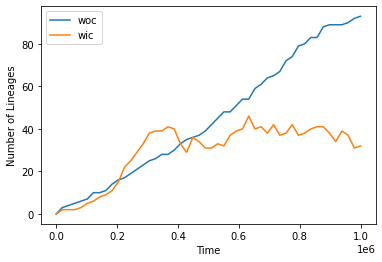

In [22]:
time_steps1 = np.linspace(0, tree1.max_distance_from_root(), 50)
time_steps2 = np.linspace(0, tree2.max_distance_from_root(), 50)
ltt1=[tree1.num_lineages_at(t) for t in time_steps1]
ltt2=[tree2.num_lineages_at(t) for t in time_steps2]
plt.plot(time_steps1, ltt1, label='woc')
plt.plot(time_steps2, ltt2, label='wic')
plt.xlabel('Time')
plt.ylabel('Number of Lineages')
plt.legend()